### We are working with the so-called "standard model" of diffusion which consist of a stick and zepplin "microstructure kernel" convolve with an arbitrary spherical distribution function (refered to as ODF)

The parameters of the microstructure kernel are $(D_{in}, D_{\parallel}, D_{\perp}, f_{in})$:  
$D_{in}$ the parallel diffusivity of the stick compartement  
$D_{\parallel}$ the parallel diffusivity of the zepplin compartement  
$D_{\perp}$ the perpendicular diffusivity of the zepplin compartement  
$f_{in}$ the signal fraction of stick compartement  
$f_{ex} = 1 - f_{in}$ the signal fraction of zepplin compartement  
This version of the model doesn't include a CSF compartement

### We define 3 sets of microstructure parameters for demonstration:

In [75]:
import numpy as np

kernels = []
kernels.append((2.5, 1.5, 0.5, 0.7)) # high diffusivity axons WM
kernels.append((1.5, 2.5, 1.0, 0.7)) # low diffusivity axons WM
kernels.append((1.0, 1.5, 1.25, 0.3)) # low axon density GM-ish

# for quick plot titleing
kernels_name = []
kernels_name.append('WM-highstick')
kernels_name.append('WM-lowstick')
kernels_name.append('GM-lowstick')

### For the ODF, we use sums of Von-Mises-Fisher distribution for simplicity.  

We will generate high density samplings for single fiber and crossings.

In [2]:
from scipy.special import erf

# dist on sphere
def sphPDF(k, mu, direc):
	# Generate the PDF for a Von-Mises Fisher distribution p=3
	# at locations direc for concentration k and mean orientation mu
	C3 = k / (2*np.pi*(np.exp(k)-np.exp(-k)))
	tmp = np.exp(k*np.dot(direc,mu[:,None])).squeeze()
	return C3*tmp

# antipodally symetric
def sphPDF_sym(k, mu, direc, norm=False):
	d1 = sphPDF(k, mu, direc)
	d2 = sphPDF(k, mu, -direc)
	dd1 = (d1+d2)/2.
	if norm:
		dd1 = dd1/dd1.sum()
	return dd1

In [23]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion724').subdivide(2) # very fine sphere ~11k points

In [47]:
ODFs = []

# sharp (concentration=16) single fiber aligned in Z
ODF = sphPDF_sym(16, np.array([1,0,0]), sphere.vertices, norm=True)
ODFs.append(ODF)

# wide (concentration=4) single fiber aligned in Y
ODF = sphPDF_sym(4, np.array([0,1,0]), sphere.vertices, norm=True)
ODFs.append(ODF)

# sharp (concentration=32) 50/50 90degree 2-fiber crossing in aligned in X-Z plane
ODF1 = sphPDF_sym(32, np.array([1,0,0]), sphere.vertices, norm=True)
ODF2 = sphPDF_sym(32, np.array([0,0,1]), sphere.vertices, norm=True)
ODF = ODF1+ODF2
ODFs.append(ODF/ODF.sum())
            
# sharp (concentration=32) 50/50 45degree 2-fiber crossing in aligned in X-Y plane
ODF1 = sphPDF_sym(32, np.array([np.cos(22.5*np.pi/180),np.sin(22.5*np.pi/180),0]), sphere.vertices, norm=True)
ODF2 = sphPDF_sym(32, np.array([np.cos(67.5*np.pi/180),np.sin(67.5*np.pi/180),0]), sphere.vertices, norm=True)
ODF = ODF1+ODF2
ODFs.append(ODF/ODF.sum())

# for quick plot titleing
ODFs_name = []
ODFs_name.append('single-sharp')
ODFs_name.append('single-wide')
ODFs_name.append('crossing-sharp_90d')
ODFs_name.append('crossing-sharp_45d')


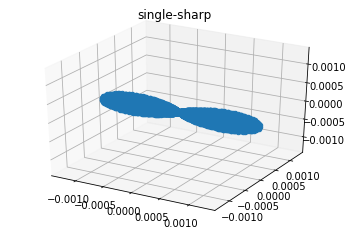

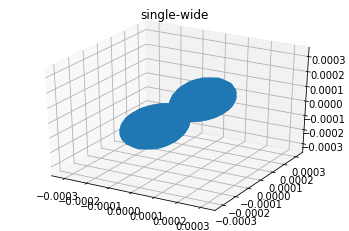

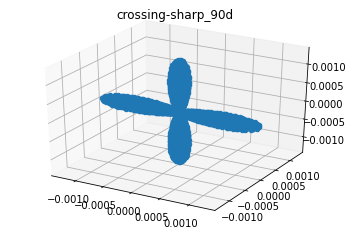

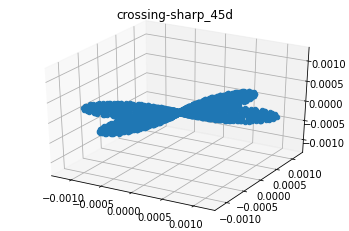

In [53]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pl

for i in range(len(ODFs)):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection='3d')

    scaled_pts = ODFs[i][:,None]*sphere.vertices
    ax.scatter(scaled_pts[:,0], scaled_pts[:,1], scaled_pts[:,2], depthshade=False)
    vizlim = (-np.abs(scaled_pts).max(), np.abs(scaled_pts).max())
    ax.set_xlim(vizlim)
    ax.set_ylim(vizlim)
    ax.set_zlim(vizlim)
    
    pl.title(ODFs_name[i])

pl.show('equal')


    pl.title(ODFs_name[i])

### We need to import a list bvec/bval (and b-tensor shapes!) to sample the signals.  
We use our "typical" 3 shells (b1-2-4), 2 type (linear and planar b-tensor) with 45 points per shells and type.  
Giving us 45 x 3 x 2 = 270 gradients.  

For simplicity we will simply copy paste the G1G2G3 here (I know it's messy but I want this to be standalone file-wise...)

In [55]:
G1G2G3 = np.array([[-1.98e-02, 5.00e-01, 4.54e-03, -1.98e-02, 5.00e-01, 4.54e-03, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.33e-02, 4.64e-01, -1.76e-01, -6.33e-02, 4.64e-01, -1.76e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.84e-01, -9.41e-02, 8.23e-02, -4.84e-01, -9.41e-02, 8.23e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.62e-02, -4.61e-01, -1.79e-01, -7.62e-02, -4.61e-01, -1.79e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.80e-01, 4.63e-01, 5.66e-02, 1.80e-01, 4.63e-01, 5.66e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[4.56e-01, -6.33e-02, -1.95e-01, 4.56e-01, -6.33e-02, -1.95e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.53e-02, 2.44e-01, -4.31e-01, 6.53e-02, 2.44e-01, -4.31e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.65e-01, -3.38e-01, 5.44e-02, 3.65e-01, -3.38e-01, 5.44e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.15e-01, 3.39e-01, 2.98e-01, 2.15e-01, 3.39e-01, 2.98e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.78e-02, -3.90e-01, 3.01e-01, -8.78e-02, -3.90e-01, 3.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.77e-01, 7.49e-02, 1.28e-01, 4.77e-01, 7.49e-02, 1.28e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.86e-01, -2.09e-01, -2.39e-01, -3.86e-01, -2.09e-01, -2.39e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.93e-01, -8.19e-02, 5.51e-03, 4.93e-01, -8.19e-02, 5.51e-03, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.35e-01, -2.44e-01, -3.78e-02, -4.35e-01, -2.44e-01, -3.78e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.89e-01, -2.15e-02, -3.13e-01, -3.89e-01, -2.15e-02, -3.13e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.32e-01, 2.35e-01, 9.16e-02, -4.32e-01, 2.35e-01, 9.16e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[1.70e-02, -8.34e-02, 4.93e-01, 1.70e-02, -8.34e-02, 4.93e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[8.37e-02, 1.01e-01, 4.82e-01, 8.37e-02, 1.01e-01, 4.82e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.11e-01, -5.32e-02, -4.85e-01, 1.11e-01, -5.32e-02, -4.85e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.15e-01, 2.70e-01, 4.05e-01, 1.15e-01, 2.70e-01, 4.05e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.92e-02, 4.19e-02, 6.68e-02, -7.92e-02, 4.19e-02, 6.68e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.48e-01, 2.05e-01, -4.31e-01, -1.48e-01, 2.05e-01, -4.31e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.98e-01, 3.37e-01, 3.11e-01, -1.98e-01, 3.37e-01, 3.11e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.39e-01, -1.66e-01, -4.07e-01, 2.39e-01, -1.66e-01, -4.07e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.54e-01, 2.51e-01, -3.50e-01, 2.54e-01, 2.51e-01, -3.50e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.32e-01, -4.66e-01, 1.25e-01, -1.32e-01, -4.66e-01, 1.25e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.20e-01, -1.64e-01, 3.48e-01, 3.20e-01, -1.64e-01, 3.48e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.58e-01, 2.22e-01, 2.69e-01, -3.58e-01, 2.22e-01, 2.69e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.70e-01, -1.53e-01, -3.92e-01, -2.70e-01, -1.53e-01, -3.92e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.92e-01, -1.08e-01, 2.91e-01, -3.92e-01, -1.08e-01, 2.91e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.63e-01, 3.60e-01, -2.26e-01, 2.63e-01, 3.60e-01, -2.26e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.04e-02, -3.55e-01, 3.40e-01, 9.04e-02, -3.55e-01, 3.40e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.37e-01, -3.83e-01, 2.18e-01, 2.37e-01, -3.83e-01, 2.18e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.15e-01, -3.62e-01, -1.42e-01, -3.15e-01, -3.62e-01, -1.42e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.03e-01, 2.47e-01, -1.64e-01, 4.03e-01, 2.47e-01, -1.64e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.07e-01, 9.15e-02, -4.46e-01, 2.07e-01, 9.15e-02, -4.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.29e-01, -4.55e-01, -1.62e-01, 1.29e-01, -4.55e-01, -1.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.99e-01, 3.75e-01, 1.42e-01, -2.99e-01, 3.75e-01, 1.42e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.43e-01, 3.30e-02, 3.62e-01, -3.43e-01, 3.30e-02, 3.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.11e-01, -4.52e-01, 2.75e-02, 2.11e-01, -4.52e-01, 2.75e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[3.18e-01, 3.82e-01, -4.95e-02, 3.18e-01, 3.82e-01, -4.95e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.40e-02, -9.05e-02, -1.50e-02, 6.40e-02, -9.05e-02, -1.50e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.70e-01, 2.61e-01, -2.13e-01, -3.70e-01, 2.61e-01, -2.13e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.60e-02, -2.38e-01, -4.34e-01, 6.60e-02, -2.38e-01, -4.34e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.50e-01, 1.12e-01, -1.87e-01, -4.50e-01, 1.12e-01, -1.87e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.24e-01, -2.55e-02, 4.46e-01, 2.24e-01, -2.55e-02, 4.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.13e-02, 3.87e-01, 3.16e-01, -1.13e-02, 3.87e-01, 3.16e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.70e-01, 1.70e-02, 1.70e-01, -1.70e-01, -1.10e-02, 4.70e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.29e-01, -1.56e-01, -4.57e-01, -4.79e-01, -1.03e-01, -1.00e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.72e-02, 4.90e-01, -1.11e-02, -7.86e-02, -2.68e-02, -4.93e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.37e-02, 1.72e-01, -4.66e-01, -4.91e-01, 9.03e-02, -2.33e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.58e-02, 3.48e-02, -4.94e-01, -4.62e-01, 1.86e-01, -4.84e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.36e-01, -4.49e-01, -1.73e-01, 1.53e-01, -2.11e-01, 4.27e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.86e-01, 5.25e-02, 1.03e-01, 9.59e-02, -4.33e-01, -2.31e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.13e-01, -1.62e-01, 4.23e-01, -2.68e-01, -3.31e-01, -2.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.78e-01, -3.15e-01, 8.53e-02, -2.46e-01, -1.89e-01, 3.92e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.47e-01, 6.44e-02, 2.14e-01, 2.06e-01, -3.06e-01, -3.37e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.77e-02, -3.31e-01, 3.72e-01, 1.40e-01, -3.67e-01, -3.09e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.14e-01, 1.94e-01, 3.37e-01, -4.83e-02, 4.11e-01, -2.81e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.90e-02, 3.95e-01, -2.98e-01, 4.45e-02, 2.95e-01, 4.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.39e-01, 4.35e-01, -6.32e-02, -6.37e-02, 3.69e-02, 4.95e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.13e-01, 1.98e-02, -3.90e-01, 2.92e-02, -4.99e-01, -2.00e-03, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.90e-03, -1.03e-01, -4.34e-02, -8.90e-03, -1.03e-01, -4.34e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.49e-01, 4.25e-01, 8.66e-02, 3.72e-02, -1.20e-01, 4.84e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.06e-02, -4.88e-01, -8.49e-02, -4.95e-01, -7.25e-02, 4.79e-03, 0.00e+00, 0.00e+00, 0.00e+00],
[8.97e-02, -4.84e-01, 8.59e-02, 4.85e-01, 7.22e-02, -9.92e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.95e-01, 4.51e-01, -9.43e-02, -4.47e-01, -2.10e-01, -7.95e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.57e-02, 4.21e-01, -2.53e-01, -4.77e-01, -1.94e-02, 1.48e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.79e-02, 4.56e-01, 2.00e-01, 4.75e-01, 1.80e-02, -1.55e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.76e-01, -3.69e-01, 2.88e-01, -4.24e-01, -4.70e-03, -2.65e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.78e-01, -1.60e-01, 2.86e-01, 2.25e-01, 4.44e-01, -4.90e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[9.68e-02, 3.63e-01, 3.30e-01, -4.20e-01, 2.35e-01, -1.35e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.30e-01, -1.72e-01, -1.87e-01, -2.17e-01, -5.83e-02, -4.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.61e-01, -2.72e-02, -3.45e-01, -1.32e-01, -4.72e-01, -1.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.00e-01, -3.93e-01, -7.56e-02, 1.78e-01, -2.16e-01, 4.15e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.94e-01, 7.19e-02, -3.00e-01, -1.48e-01, 4.71e-01, -8.15e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.66e-02, -4.43e-01, -2.27e-01, 3.07e-01, -2.05e-01, 3.37e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.97e-01, -1.32e-01, -4.40e-01, -3.77e-01, 3.21e-01, 7.22e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[1.54e-01, 3.49e-01, 3.23e-01, 4.67e-01, -4.62e-02, -1.72e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.57e-02, 2.30e-01, 4.43e-01, -4.39e-01, -2.25e-01, 8.16e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.86e-01, 3.13e-01, 5.69e-02, 4.78e-02, 1.45e-01, -4.76e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.83e-01, -1.12e-02, -4.65e-01, 2.34e-01, -4.35e-01, -8.12e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.02e-01, 4.87e-01, 5.23e-02, -4.43e-01, -6.96e-02, -2.20e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.09e-01, -1.65e-02, 1.67e-02, 1.09e-01, -1.65e-02, 1.67e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[1.43e-01, 1.96e-01, -4.37e-01, 4.62e-01, 6.68e-02, 1.80e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.41e-01, -2.71e-02, -4.37e-01, 3.20e-01, 3.30e-01, -1.97e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.33e-01, -2.29e-01, -2.95e-01, 1.46e-01, -4.43e-01, 1.79e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.62e-01, 1.04e-01, 4.62e-01, -4.23e-01, -1.86e-01, 1.90e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.85e-01, 3.11e-01, -7.07e-02, -2.33e-02, 8.31e-02, 4.92e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.87e-01, 7.83e-02, -4.02e-01, 1.77e-01, 4.19e-01, 2.08e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.07e-02, 4.36e-01, -2.44e-01, -4.95e-01, -5.89e-02, -4.28e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.05e-01, 7.24e-02, -4.50e-01, 7.36e-02, 4.82e-01, 1.11e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.01e-01, -4.84e-01, -7.80e-02, -4.36e-01, -1.25e-01, 2.11e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.99e-01, -1.07e-02, 3.08e-02, -3.06e-02, -3.16e-01, 3.86e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.34e-01, 3.64e-01, 5.59e-01, -2.34e-01, 3.64e-01, 5.59e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.47e-01, 5.29e-01, 3.16e-01, 3.47e-01, 5.29e-01, 3.16e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.28e-01, -2.58e-01, -6.17e-01, -2.28e-01, -2.58e-01, -6.17e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.09e-01, 6.23e-01, 1.28e-01, -3.09e-01, 6.23e-01, 1.28e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.01e-01, 2.50e-01, 2.76e-01, -6.01e-01, 2.50e-01, 2.76e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.44e-01, 2.90e-01, -5.97e-01, 2.44e-01, 2.90e-01, -5.97e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.47e-01, -6.91e-01, 2.61e-02, -1.47e-01, -6.91e-01, 2.61e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.59e-01, -2.55e-01, -1.27e-02, 6.59e-01, -2.55e-01, -1.27e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.00e-02, 1.94e-01, 6.79e-01, -4.00e-02, 1.94e-01, 6.79e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.77e-01, 2.00e-01, 4.38e-02, 6.77e-01, 2.00e-01, 4.38e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.40e-02, 3.82e-02, -1.04e-01, -1.40e-02, 3.82e-02, -1.04e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.50e-01, 5.85e-01, -1.88e-01, 3.50e-01, 5.85e-01, -1.88e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.86e-01, 3.48e-01, -1.88e-01, -5.86e-01, 3.48e-01, -1.88e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.42e-01, 6.87e-01, -8.99e-02, -1.42e-01, 6.87e-01, -8.99e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.35e-01, -6.81e-02, 6.91e-01, -1.35e-01, -6.81e-02, 6.91e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.56e-01, -4.28e-01, 8.68e-02, -5.56e-01, -4.28e-01, 8.68e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.99e-01, -9.16e-02, -6.34e-01, 2.99e-01, -9.16e-02, -6.34e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.68e-02, 2.54e-01, -6.58e-01, -4.68e-02, 2.54e-01, -6.58e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.43e-01, 1.74e-01, -5.94e-01, -3.43e-01, 1.74e-01, -5.94e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.30e-01, -5.93e-01, -3.62e-01, -1.30e-01, -5.93e-01, -3.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.06e-01, -1.51e-01, -3.32e-01, -6.06e-01, -1.51e-01, -3.32e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.49e-01, 1.27e-01, -5.31e-01, 4.49e-01, 1.27e-01, -5.31e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.95e-01, 1.87e-02, 1.27e-01, -6.95e-01, 1.87e-02, 1.27e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.69e-01, -4.96e-01, 4.26e-01, -2.69e-01, -4.96e-01, 4.26e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.59e-01, 2.12e-01, 4.94e-01, -4.59e-01, 2.12e-01, 4.94e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.32e-02, 4.40e-01, 5.52e-01, 3.32e-02, 4.40e-01, 5.52e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.82e-01, -5.90e-01, -7.95e-02, -3.82e-01, -5.90e-01, -7.95e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[4.04e-01, -4.57e-01, -3.58e-01, 4.04e-01, -4.57e-01, -3.58e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.64e-01, -5.72e-01, -3.82e-01, 1.64e-01, -5.72e-01, -3.82e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.28e-01, -2.17e-01, 2.43e-01, -6.28e-01, -2.17e-01, 2.43e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.59e-01, 8.15e-04, -6.89e-01, -1.59e-01, 8.15e-04, -6.89e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.32e-02, -5.82e-02, 6.13e-02, 7.32e-02, -5.82e-02, 6.13e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.24e-01, -4.08e-01, 5.33e-01, 2.24e-01, -4.08e-01, 5.33e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.65e-01, -3.78e-01, 3.75e-01, -4.65e-01, -3.78e-01, 3.75e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.62e-02, 6.86e-01, 1.69e-01, -3.62e-02, 6.86e-01, 1.69e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.63e-01, -1.24e-01, 4.10e-01, 5.63e-01, -1.24e-01, 4.10e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.91e-01, -5.92e-01, 3.35e-01, 1.91e-01, -5.92e-01, 3.35e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.96e-02, 4.81e-01, -5.18e-01, 2.96e-02, 4.81e-01, -5.18e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.29e-01, 7.64e-02, 5.57e-01, 4.29e-01, 7.64e-02, 5.57e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.19e-01, -4.65e-01, -1.21e-01, 5.19e-01, -4.65e-01, -1.21e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.29e-01, 3.35e-01, 4.52e-01, 4.29e-01, 3.35e-01, 4.52e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.03e-01, 5.63e-01, -1.45e-01, -4.03e-01, 5.63e-01, -1.45e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.48e-02, -6.43e-01, 2.85e-01, -7.48e-02, -6.43e-01, 2.85e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.57e-01, 3.90e-01, 1.95e-01, 5.57e-01, 3.90e-01, 1.95e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.90e-01, 2.22e-03, -3.90e-01, 5.90e-01, 2.22e-03, -3.90e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.86e-01, -4.91e-02, 1.66e-01, 6.86e-01, -4.91e-02, 1.66e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.27e-01, 3.94e-01, -4.04e-01, -4.27e-01, 3.94e-01, -4.04e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.00e-01, -3.74e-01, -8.20e-03, 2.92e-01, -4.78e-01, 4.32e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.04e-01, 7.90e-02, -5.75e-01, -4.65e-01, 4.63e-01, -2.63e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.27e-01, 5.58e-01, -7.55e-02, 5.15e-01, 3.49e-01, -3.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.08e-01, 1.56e-01, 4.66e-01, -3.83e-01, -2.95e-01, 5.16e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.11e-01, -6.21e-01, 3.20e-01, 3.56e-01, 2.29e-01, 5.67e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.01e-02, -6.87e-02, -3.71e-02, -8.01e-02, -6.87e-02, -3.71e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.57e-01, -1.94e-01, 1.74e-01, -9.27e-02, -6.15e-01, -3.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.17e-01, -1.19e-01, 3.24e-01, 3.12e-01, -9.01e-02, -6.28e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.52e-01, -3.63e-01, -5.88e-01, 2.06e-01, 5.51e-01, -3.93e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.97e-01, 1.19e-01, 7.17e-03, -1.12e-01, 6.69e-01, -1.98e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.03e-01, -2.01e-01, -6.70e-01, 1.77e-01, -6.48e-01, 2.21e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.05e-01, -2.70e-01, -6.45e-01, -6.06e-01, 2.91e-01, -2.20e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.61e-01, -8.72e-02, 6.51e-01, -2.98e-01, -6.09e-01, -2.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.79e-01, -1.64e-01, -4.93e-01, 5.00e-01, 3.84e-02, -4.99e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.51e-01, 4.39e-01, -6.39e-02, -4.23e-01, -5.50e-01, -1.37e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.36e-01, 5.50e-01, -8.69e-02, -1.50e-02, -1.22e-01, -6.96e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.32e-01, -7.53e-02, 3.09e-01, 1.08e-01, 6.97e-01, -5.00e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.77e-01, -1.69e-01, -1.13e-01, -1.98e-01, -6.38e-01, -2.32e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.92e-01, 1.03e-01, 3.72e-01, 1.78e-01, 6.78e-01, 9.59e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[9.55e-02, 3.50e-01, -6.07e-01, -6.88e-01, 1.61e-01, -1.58e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.45e-01, 2.82e-02, 6.16e-01, -1.19e-01, 6.90e-01, -9.81e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.68e-01, -4.38e-01, -4.16e-01, 4.04e-01, -5.41e-01, 2.12e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.74e-02, 7.05e-01, 4.64e-02, -1.26e-01, 5.06e-02, -6.94e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.00e-01, -3.71e-01, -5.24e-02, -2.60e-01, -3.42e-01, -5.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.89e-01, -1.05e-01, 5.00e-01, 2.24e-01, 6.66e-01, -7.87e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.36e-02, -5.45e-01, 4.40e-01, 7.00e-01, -9.38e-02, 3.27e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[5.43e-02, 2.79e-02, -9.37e-02, 5.43e-02, 2.79e-02, -9.37e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[5.87e-01, -3.89e-01, 6.14e-02, -9.49e-02, -3.29e-02, 7.00e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.83e-02, 4.56e-01, -5.39e-01, 5.79e-01, 2.88e-01, 2.85e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.32e-01, -3.91e-01, 4.01e-01, -5.36e-01, 1.40e-01, -4.40e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.06e-01, 6.73e-01, 6.91e-02, -2.53e-01, -9.46e-03, -6.60e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.89e-01, 3.78e-04, -1.59e-01, 1.85e-04, -7.07e-01, -8.79e-04, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.79e-01, -4.90e-01, -1.74e-01, -4.69e-01, 3.06e-01, 4.31e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.95e-01, 4.92e-01, -1.18e-01, -1.98e-01, -3.40e-01, -5.88e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.09e-01, 1.16e-01, -3.40e-01, 3.57e-01, -1.28e-01, 5.97e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.61e-02, -6.83e-01, -1.84e-01, 4.28e-01, 1.37e-01, -5.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.89e-01, 3.19e-01, 2.27e-01, 3.41e-01, -2.18e-01, -5.80e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.17e-01, -5.14e-01, -4.71e-01, -6.97e-01, -6.59e-02, -1.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.82e-01, -3.09e-01, 4.14e-01, -2.88e-01, 6.31e-01, 1.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.87e-01, -5.10e-01, 2.99e-01, -2.84e-01, -1.54e-01, -6.29e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.40e-01, -4.05e-01, 5.28e-01, -5.09e-01, 4.73e-01, 1.33e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.51e-01, -6.88e-02, -6.87e-01, 5.61e-01, 4.22e-01, 8.09e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.94e-01, -1.15e-01, -7.65e-02, -1.16e-01, -2.71e-01, -6.43e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.67e-01, 5.55e-01, -3.48e-01, 3.45e-01, -2.00e-01, -5.84e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.88e-01, -7.35e-02, -5.87e-01, 4.23e-02, -7.03e-01, 6.01e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[1.67e-01, 1.97e-02, -6.87e-01, 4.31e-02, 7.05e-01, 3.07e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.45e-01, -1.59e-01, 4.21e-01, -1.44e-01, -5.66e-01, -3.99e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.01e-01, 3.17e-02, -3.46e-02, 1.01e-01, 3.17e-02, -3.46e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[3.52e-01, -8.98e-01, 2.65e-01, 3.52e-01, -8.98e-01, 2.65e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.52e-01, 6.03e-01, 4.59e-01, 6.52e-01, 6.03e-01, 4.59e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.95e-01, -8.57e-01, -3.30e-01, -3.95e-01, -8.57e-01, -3.30e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.77e-02, -8.92e-01, -4.49e-01, 5.77e-02, -8.92e-01, -4.49e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.44e-01, 6.70e-01, -3.69e-01, -6.44e-01, 6.70e-01, -3.69e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.38e-01, 4.99e-01, 7.48e-01, 4.38e-01, 4.99e-01, 7.48e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.89e-01, -1.55e-01, -9.08e-01, -3.89e-01, -1.55e-01, -9.08e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.63e-02, 5.43e-01, -8.35e-01, -8.63e-02, 5.43e-01, -8.35e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.39e-01, 3.35e-01, -7.73e-01, 5.39e-01, 3.35e-01, -7.73e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[8.35e-01, -5.50e-01, 1.73e-02, 8.35e-01, -5.50e-01, 1.73e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.10e-01, -7.23e-01, -6.58e-01, -2.10e-01, -7.23e-01, -6.58e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.58e-01, -3.84e-01, 5.28e-01, -7.58e-01, -3.84e-01, 5.28e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.88e-01, -4.39e-01, 7.54e-01, 4.88e-01, -4.39e-01, 7.54e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.87e-01, -6.07e-01, 7.41e-01, -2.87e-01, -6.07e-01, 7.41e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.92e-01, -3.01e-01, -9.08e-01, 2.92e-01, -3.01e-01, -9.08e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.42e-01, -5.61e-01, -3.68e-01, 7.42e-01, -5.61e-01, -3.68e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.25e-01, -6.83e-01, -8.58e-02, -7.25e-01, -6.83e-01, -8.58e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[9.00e-01, 5.09e-03, 4.36e-01, 9.00e-01, 5.09e-03, 4.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.44e-01, -2.47e-01, -2.19e-01, 9.44e-01, -2.47e-01, -2.19e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.75e-01, -7.07e-01, 6.00e-01, 3.75e-01, -7.07e-01, 6.00e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.35e-02, 1.02e-01, -4.45e-02, -1.35e-02, 1.02e-01, -4.45e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.39e-01, 2.88e-01, -1.90e-01, -9.39e-01, 2.88e-01, -1.90e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.04e-01, 4.07e-01, -1.33e-01, 9.04e-01, 4.07e-01, -1.33e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.44e-01, 9.57e-02, -7.59e-01, -6.44e-01, 9.57e-02, -7.59e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.18e-01, -2.62e-01, -6.44e-01, -7.18e-01, -2.62e-01, -6.44e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.54e-02, -9.78e-01, 2.06e-01, -3.54e-02, -9.78e-01, 2.06e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.39e-01, 8.95e-01, -8.29e-02, 4.39e-01, 8.95e-01, -8.29e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.91e-01, -2.80e-01, 9.41e-01, -1.91e-01, -2.80e-01, 9.41e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.92e-01, -3.60e-01, -2.73e-01, -8.92e-01, -3.60e-01, -2.73e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.36e-01, 9.80e-01, 1.48e-01, 1.36e-01, 9.80e-01, 1.48e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.85e-01, 1.99e-01, 5.87e-01, -7.85e-01, 1.99e-01, 5.87e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.79e-01, -3.59e-01, 5.14e-01, 7.79e-01, -3.59e-01, 5.14e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.16e-02, 8.31e-01, -5.56e-01, -3.16e-02, 8.31e-01, -5.56e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.70e-01, -6.69e-01, 3.23e-01, -6.70e-01, -6.69e-01, 3.23e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-6.00e-01, 7.99e-01, 4.06e-02, -6.00e-01, 7.99e-01, 4.06e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[3.37e-01, 8.31e-01, -4.41e-01, 3.37e-01, 8.31e-01, -4.41e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.68e-02, -4.90e-02, -9.99e-01, 1.68e-02, -4.90e-02, -9.99e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.88e-01, 6.58e-01, 7.29e-01, -1.88e-01, 6.58e-01, 7.29e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.56e-01, -2.09e-01, 9.44e-01, 2.56e-01, -2.09e-01, 9.44e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.40e-01, 4.92e-01, 6.83e-01, -5.40e-01, 4.92e-01, 6.83e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.42e-01, 8.17e-03, 8.40e-01, -5.42e-01, 8.17e-03, 8.40e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.75e-03, -4.97e-02, -9.98e-02, 7.75e-03, -4.97e-02, -9.98e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.33e-01, 7.97e-01, 4.20e-01, -4.33e-01, 7.97e-01, 4.20e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.97e-01, 6.54e-02, 3.02e-02, 9.97e-01, 6.54e-02, 3.02e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-2.51e-01, 9.63e-01, 1.01e-01, -2.51e-01, 9.63e-01, 1.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.17e-01, 9.77e-02, -3.86e-01, 9.17e-01, 9.77e-02, -3.86e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.20e-02, -4.16e-01, -9.06e-01, -8.20e-02, -4.16e-01, -9.06e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.24e-02, -2.75e-01, -9.61e-01, 9.36e-01, 3.44e-01, -7.67e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.59e-01, -1.52e-01, -7.36e-01, 3.74e-01, -7.83e-01, 4.97e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.18e-01, -3.57e-01, -1.73e-01, 3.05e-02, -3.71e-01, 9.28e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.03e-01, 3.91e-01, -8.28e-01, 9.14e-01, 2.29e-01, -3.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.37e-01, 4.15e-01, -5.33e-01, 2.03e-01, 6.16e-01, 7.61e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.54e-01, 7.78e-01, -6.09e-01, -8.86e-01, 3.82e-01, 2.64e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.21e-01, -5.06e-02, -3.86e-01, -1.37e-02, 9.87e-01, -1.62e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.96e-01, -2.60e-02, 8.60e-02, 2.50e-02, 8.39e-01, 5.43e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.62e-01, 8.06e-01, 5.31e-01, -8.01e-01, 4.89e-01, -3.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.50e-01, -8.31e-01, 8.58e-02, -3.29e-02, -8.11e-02, -9.96e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[2.22e-01, 6.20e-01, -7.52e-01, -9.52e-01, 3.04e-01, -3.05e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.04e-01, -7.19e-01, 3.44e-01, 2.48e-01, 5.79e-01, 7.77e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.09e-01, 7.90e-01, 6.64e-02, 6.25e-01, -4.27e-01, -6.53e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.94e-01, -5.69e-01, -6.57e-01, -8.21e-01, 5.55e-01, 1.36e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.80e-01, 9.08e-01, -1.79e-01, -8.78e-01, 2.93e-01, -3.79e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.48e-02, 2.01e-02, 8.89e-02, 6.48e-02, 2.01e-02, 8.89e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[2.15e-01, -3.21e-01, 9.23e-01, -6.35e-01, -7.63e-01, -1.17e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.47e-01, -7.19e-01, 2.54e-01, 2.35e-01, -1.28e-01, -9.63e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.89e-01, -4.58e-01, -7.99e-01, 1.96e-01, 8.89e-01, -4.15e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[8.28e-02, -4.65e-01, 8.82e-01, -3.19e-01, -8.50e-01, -4.18e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.21e-01, 3.57e-01, -1.55e-01, 1.05e-01, -6.11e-01, -7.85e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.89e-01, 2.95e-02, 9.81e-01, -2.88e-01, -9.57e-01, -2.69e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-1.89e-01, 1.01e-01, -9.77e-01, 3.84e-01, -9.08e-01, -1.69e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.56e-01, -6.61e-02, -6.51e-01, -1.12e-01, -9.93e-01, -2.98e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[6.48e-01, 8.46e-02, -7.57e-01, 2.53e-01, -9.61e-01, 1.09e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.96e-01, -5.07e-02, -6.93e-02, -7.82e-02, -2.03e-01, -9.76e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-7.65e-01, 3.23e-01, -5.58e-01, -4.72e-01, 3.08e-01, 8.26e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.45e-01, 9.17e-01, 2.02e-01, 9.19e-01, 2.86e-01, 2.72e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[3.64e-01, -9.31e-01, 3.80e-02, 2.68e-01, 6.56e-02, -9.61e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-9.71e-01, 1.62e-01, -1.78e-01, 1.99e-01, 1.20e-01, -9.73e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[4.81e-01, 7.93e-01, 3.74e-01, -3.91e-01, 5.76e-01, -7.18e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-4.88e-01, -8.61e-01, 1.39e-01, 3.93e-01, -3.59e-01, -8.46e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[9.48e-01, -1.51e-01, -2.80e-01, -3.17e-01, -5.36e-01, -7.83e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.26e-01, -6.81e-01, 9.48e-02, 1.56e-01, 2.98e-01, 9.42e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.29e-01, 5.03e-01, -5.93e-01, 4.94e-01, 3.30e-01, 8.04e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.98e-01, 1.73e-01, 7.83e-01, 7.27e-01, -5.28e-01, -4.39e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-5.48e-02, -9.13e-02, 3.41e-02, -5.48e-02, -9.13e-02, 3.41e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.61e-02, -9.98e-01, 4.83e-02, 9.99e-01, -3.52e-02, 1.85e-02, 0.00e+00, 0.00e+00, 0.00e+00],
[-8.35e-01, -4.98e-01, 2.33e-01, 5.16e-01, -5.65e-01, 6.43e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[7.41e-01, 6.70e-01, -5.23e-02, 6.21e-01, -7.13e-01, -3.26e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.06e-01, 8.38e-01, -2.03e-01, -6.73e-01, 2.36e-01, -7.01e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.33e-01, -6.54e-01, 4.14e-01, 5.53e-01, 7.56e-01, 3.49e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[5.93e-01, 6.03e-01, -5.33e-01, 6.78e-01, -1.80e-02, 7.35e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.71e-02, -6.91e-01, -7.19e-01, 2.62e-02, -7.20e-01, 6.94e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[6.95e-01, 1.07e-01, 7.11e-01, -6.74e-01, -2.49e-01, 6.96e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[-3.85e-01, 4.61e-01, -7.99e-01, -9.97e-02, -8.82e-01, -4.60e-01, 0.00e+00, 0.00e+00, 0.00e+00],
[1.69e-03, -9.09e-01, 4.17e-01, -9.97e-01, 3.27e-02, 7.52e-02, 0.00e+00, 0.00e+00, 0.00e+00]])

In [58]:
## 3-gradient form to B-tensor
def table2ten(gtable, bval = 1000.):
	tensors_1 = np.zeros((gtable.shape[0], 3, 3))
	tensors_2 = np.zeros((gtable.shape[0], 3, 3))
	tensors_3 = np.zeros((gtable.shape[0], 3, 3))

	for ix in range(3):
		for iy in range(3):
			tensors_1[:, ix, iy] = gtable[:, ix]*gtable[:, iy]
			tensors_2[:, ix, iy] = gtable[:, ix+3]*gtable[:, iy+3]
			tensors_3[:, ix, iy] = gtable[:, ix+6]*gtable[:, iy+6]

	ten = bval * (tensors_1 + tensors_2 + tensors_3)
	return ten


def precompute_pb(bten, w):
	# precompute pb for each "tissue orientation" w from the odf sphere 
	tmp = np.zeros((w.shape[0], bten.shape[0]))
	for i in range(w.shape[0]):
		n = w[i]
		pb = np.outer(n[0]**2, bten[:,0,0]) + np.outer(n[1]**2, bten[:,1,1]) + np.outer(n[2]**2, bten[:,2,2]) + 2*np.outer(n[0]*n[1], bten[:,0,1]) + 2*np.outer(n[0]*n[2], bten[:,0,2]) + 2*np.outer(n[1]*n[2], bten[:,1,2])
		tmp[i] = pb
	return tmp

In [68]:
# compute and bvalue normalize b-tensor from G1G2G3 
bten = table2ten(G1G2G3, bval=4/2.)
bten_bval = np.trace(bten, axis1=1, axis2=2)

# detect linear or planar shape
G1G2_dist = np.linalg.norm(G1G2G3[:,0:3] - G1G2G3[:,3:6], axis=1)
dirtype = np.where(G1G2_dist<1e-6, 'lin', 'pla')

# little bit of cleaning for rounding errors (from clipping digit in the copypasted G1G2G3) 
#  and to remove the uneeded b0s )(b0=1 in the simulations)
keepidx = bten_bval > 0.5
bten_bval = bten_bval[keepidx]
bten = bten[keepidx]
dirtype = dirtype[keepidx]
bten_bval[np.logical_and(bten_bval>0.9, bten_bval<1.1)] = 1
bten_bval[np.logical_and(bten_bval>1.9, bten_bval<2.1)] = 2
bten_bval[np.logical_and(bten_bval>3.9, bten_bval<4.1)] = 4


# precompute tensor product for signal generate
pbs = precompute_pb(bten, sphere.vertices)

### Now we can generate the signals on the sphere for each microstructure and ODF

In [71]:
# Signal generation functions

## non spherical mean signal generation
def genSig_stick(pb, D):
	return np.exp(-pb*D)

def genSig_zep(pb, b, D_para, D_perp):
	return np.exp(-pb*D_para - (b-pb)*D_perp)

# stick + tensor
def genSig_1orientation(pb, b, D_in, D_para, D_perp, f_in):
	f_ex = 1 - f_in
	S_in = genSig_stick(pb, D_in)
	S_ex = genSig_zep(pb, b, D_para, D_perp)
	return f_in*S_in + f_ex*S_ex

def genSig_for_odf(pbs, b, odf, D_in, D_para, D_perp, f_in):
	# for each odf orientation, we gen signal
	signals = np.zeros_like(pbs)
	for i in range(pbs.shape[0]):
		signals[i] = genSig_1orientation(pbs[i], b, D_in, D_para, D_perp, f_in)
	# multiply each by odf weight and sum over odf
	return np.sum(odf[:,None]*signals, axis=0)


In [72]:
data = np.zeros((len(kernels), len(ODFs), pbs.shape[1]))

for iparam in range(len(kernels)):
    param = kernels[iparam]
    for iodf in range(len(ODFs)):
        ODF = ODFs[iodf]
        data[iparam, iodf] = genSig_for_odf(pbs, bten_bval, ODF, *param)

### First, we can check for each bval and shape if the spherical mean signal is really invariant to ODF

In [78]:
# spherical means
smtyp = [(1,'lin'), (1,'pla'), (2,'lin'), (2,'pla'), (4,'lin'), (4,'pla')]

data_SM = np.zeros((len(kernels), len(ODFs), len(smtyp)))
# also record std for later
data_SM_std = np.zeros((len(kernels), len(ODFs), len(smtyp)))


for i in range(len(smtyp)):
    shell_idx = np.logical_and(bten_bval==smtyp[i][0], dirtype==smtyp[i][1])
    data_SM[:,:,i] = data[:,:,shell_idx].mean(2)
    data_SM_std[:,:,i] = data[:,:,shell_idx].std(2)


In [80]:
print('Each row should be approximatively constant if ODF invariance')
for iparam in range(len(kernels)):
    print('\n \n ')
    print(kernels_name[iparam])
    for i in range(len(smtyp)):
        print(smtyp[i])
        print(data_SM[iparam,:,i])
        #print(data_SM_std[iparam,:,i])
        print('\n')

Each row should be approximatively constant if ODF invariance

 
 
WM-highstick
(1, 'lin')
[0.5203936  0.51757049 0.51908763 0.51732982]


(1, 'pla')
[0.45803411 0.45990237 0.45899446 0.46019204]


(2, 'lin')
[0.34237824 0.34431189 0.34174974 0.34440674]


(2, 'pla')
[0.23945627 0.23786165 0.2398609  0.2383289 ]


(4, 'lin')
[0.21473797 0.21302204 0.21555713 0.21378121]


(4, 'pla')
[0.09431772 0.09457222 0.09341756 0.09399806]



 
 
WM-lowstick
(1, 'lin')
[0.53928578 0.53694947 0.53820659 0.53671707]


(1, 'pla')
[0.50337268 0.50481492 0.50411609 0.50502183]


(2, 'lin')
[0.37288214 0.37471523 0.37233377 0.37456954]


(2, 'pla')
[0.30395794 0.30257944 0.30431647 0.30299361]


(4, 'lin')
[0.25567094 0.25399055 0.25658872 0.25487136]


(4, 'pla')
[0.14859429 0.14899206 0.14765933 0.14827069]



 
 
GM-lowstick
(1, 'lin')
[0.40970173 0.40884693 0.40930704 0.4087508 ]


(1, 'pla')
[0.4016979  0.40218513 0.40194991 0.40225055]


(2, 'lin')
[0.22833139 0.22908362 0.22812287 0.22895833]


(

### Everything in order here. Let's compare with analytical ground truth for means

In [81]:
from scipy.special import erf
import scipy as sp

bd = {}
bd['lin'] = 1.0
bd['pla'] = -0.5


# Lampinen etal. (2019 )Searching for the neurite density with diffusion MRI: Challenges for biophysical modeling
def gfunc(alpha):
	# return sp.sqrt(np.pi/(4*alpha)) * erf(sp.sqrt(alpha))
	tmp = sp.sqrt(np.pi/np.float64(4.*alpha)) * erf(sp.sqrt(alpha))
	return np.where(np.abs(alpha)<1e-16, 1., np.abs(tmp)) # the abs is missing from the paper

# generic signal formula for any b-tensor shape and any D-tensor shape
def sm_signal_generic(b, bd, Di, Dd):
	return np.exp(-b*Di*(1-bd*Dd)) * gfunc(3*b*Di*bd*Dd)

def Di_from_param(Dpar, Dperp):
	return (Dpar+2*Dperp)/3.

def Dd_from_param(Dpar, Dperp):
	return (Dpar-Dperp)/float(Dpar+2*Dperp)

def sm_signal_generic_reparam(b, bd, Dpar, Dperp):
	Di = Di_from_param(Dpar, Dperp)
	Dd = Dd_from_param(Dpar, Dperp)
	return sm_signal_generic(b, bd, Di, Dd)

In [82]:
# analytical spherical means
smtyp = [(1,'lin'), (1,'pla'), (2,'lin'), (2,'pla'), (4,'lin'), (4,'pla')]

data_SM_gt = np.zeros((len(kernels), 1, len(smtyp)))

for iparam in range(len(kernels)):
    param = kernels[iparam]
    for i in range(len(smtyp)):
        S_stick = sm_signal_generic_reparam(smtyp[i][0], bd[smtyp[i][1]], param[0], 0) # stick
        S_zep = sm_signal_generic_reparam(smtyp[i][0], bd[smtyp[i][1]], param[1], param[2]) # zepplin
        data_SM_gt[iparam, 0, i] = param[3]*S_stick + (1-param[3])*S_zep

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  if sys.path[0] == '':


In [83]:
print('Each row is GT vs mean(simulated)')
for iparam in range(len(kernels)):
    print('\n \n ')
    print(kernels_name[iparam])
    for i in range(len(smtyp)):
        print(smtyp[i])
        print(data_SM_gt[iparam,0,i], data_SM[iparam,:,i].mean())
        print('\n')

Each row is GT vs mean(simulated)

 
 
WM-highstick
(1, 'lin')
0.5182959004388146 0.5185953862693827


(1, 'pla')
0.4594870106561078 0.45928074398401636


(2, 'lin')
0.34301208160054186 0.34321165366682066


(2, 'pla')
0.23878901480312964 0.2388769297732246


(4, 'lin')
0.21407968358313656 0.21427458554085504


(4, 'pla')
0.09398550735895889 0.09407639138684351



 
 
WM-lowstick
(1, 'lin')
0.5375556146651214 0.5377897261671594


(1, 'pla')
0.5045003642189504 0.5043313777250489


(2, 'lin')
0.3735171357337521 0.3736251684499719


(2, 'pla')
0.3034052628488649 0.30346186582612245


(4, 'lin')
0.2551126284214071 0.2552803943065518


(4, 'pla')
0.14830313769880765 0.14837909292661736



 
 
GM-lowstick
(1, 'lin')
0.40907014929659363 0.409151624169134


(1, 'pla')
0.4020807209508264 0.4020208723456742


(2, 'lin')
0.22860695092012012 0.22862405232696664


(2, 'pla')
0.21019965601180501 0.21021440620429918


(4, 'lin')
0.13583465161153288 0.13589212829475567


(4, 'pla')
0.09941667437481935